# The IRIS Builder for approximate convex decompositions of configuration space

[IRIS in Configuration Space](https://drake.mit.edu/doxygen_cxx/group__geometry__optimization.html#ga3a51e0fec449a0abcf498f78a2a390a8) is a surprisingly effective and very useful tools for decomposing the (collision-free) configuration space into convex sets. IRIS itself only creates one convex region, but this notebook provides a number of algorithms and tools for calling IRIS in Configuration Space repeatedly to achieve an approximate convex cover of the space.

The current version of the notebook uses the [IRIS-NP](https://arxiv.org/abs/2303.14737) algorithm -- which uses random samples to seed nonlinear optimization to find counter-examples. The certification of non-collision is only probabilistic -- the more samples you take, the more likely you are to have found all possible collisions. For rigorous certification of non-collision, we have [C-IRIS](https://arxiv.org/abs/2302.12219), which uses sums-of-squares optimization to guarantee non-collision. The final public implementation of that algorithm is under active development -- we will add it to the notebook soon!

## How to use this notebook

<center><iframe width="560" height="315" src="https://www.youtube.com/embed/vaFlIxtiz4M" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe></center>

The first few cells are used to set up your robot/environment and your IRIS configuration options. The rest of the cells are optional... you might run some of them multiple times, and might not use all of them. They are provided as a suite of tools for you to work with.

In [1]:
import multiprocessing as mp
import os.path
import time
from collections import OrderedDict
from typing import Dict

import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.common.value import AbstractValue
from pydrake.geometry import (
    Meshcat,
    MeshcatVisualizer,
    QueryObject,
    Rgba,
    Role,
    SceneGraph,
    Sphere,
    StartMeshcat,
)
from pydrake.geometry.optimization import (
    HPolyhedron,
    IrisInConfigurationSpace,
    IrisOptions,
    LoadIrisRegionsYamlFile,
    SaveIrisRegionsYamlFile,
)
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix
from pydrake.multibody.inverse_kinematics import InverseKinematics
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, MultibodyPlant
from pydrake.multibody.tree import Body
from pydrake.solvers import MathematicalProgram, Solve
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer

from manipulation import running_as_notebook
from manipulation.utils import FindDataResource

In [2]:
# Start the visualizer (only run this once).
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


# Setup



In [3]:
# iris_filename = "my_iris.yaml"
iris_filename = FindDataResource("iiwa_shelve_and_bins_science_robotics.yaml")
iris_regions = dict()
q = []

## Configure IRIS

You can find the documentation for IrisOptions [here](https://drake.mit.edu/doxygen_cxx/structdrake_1_1geometry_1_1optimization_1_1_iris_options.html).

In [4]:
iris_options = IrisOptions()
iris_options.iteration_limit = 10
# increase num_collision_infeasible_samples to improve the (probabilistic)
# certificate of having no collisions.
iris_options.num_collision_infeasible_samples = 3
iris_options.require_sample_point_is_contained = True
iris_options.relative_termination_threshold = 0.01
iris_options.termination_threshold = -1

# Additional options for this notebook:

# If use_existing_regions_as_obstacles is True, then iris_regions will be
# shrunk by regions_as_obstacles_margin, and then passed to
# iris_options.configuration_obstacles.
use_existing_regions_as_obstacles = True
regions_as_obstacles_scale_factor = 0.95

# We can compute some regions in parallel.
num_parallel = mp.cpu_count()

## Some helper/worker methods

In [5]:
def ScaleHPolyhedron(hpoly, scale_factor):
    # Shift to the center.
    xc = hpoly.ChebyshevCenter()
    A = hpoly.A()
    b = hpoly.b() - A @ xc
    # Scale
    b = scale_factor * b
    # Shift back
    b = b + A @ xc
    return HPolyhedron(A, b)


def _CheckNonEmpty(region):
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(region.ambient_dimension())
    region.AddPointInSetConstraints(prog, x)
    result = Solve(prog)
    assert result.is_success()


def _CalcRegion(name, seed):
    builder = DiagramBuilder()
    plant = AddMultibodyPlantSceneGraph(builder, 0.0)[0]
    LoadRobot(plant)
    plant.Finalize()
    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    plant.SetPositions(plant_context, seed)
    if use_existing_regions_as_obstacles:
        iris_options.configuration_obstacles = [
            ScaleHPolyhedron(r, regions_as_obstacles_scale_factor)
            for k, r in iris_regions.items()
            if k != name
        ]
        for h in iris_options.configuration_obstacles:
            _CheckNonEmpty(h)
    else:
        iris_options.configuration_obstacles = None
    display(f"Computing region for seed: {name}")
    start_time = time.time()
    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    display(
        f"Finished seed {name}; Computation time: {(time.time() - start_time):.2f} seconds"
    )

    _CheckNonEmpty(hpoly)
    reduced = hpoly.ReduceInequalities()
    _CheckNonEmpty(reduced)

    return reduced


def GenerateRegion(name, seed):
    global iris_regions
    iris_regions[name] = _CalcRegion(name, seed)
    SaveIrisRegionsYamlFile(f"{iris_filename}.autosave", iris_regions)


def GenerateRegions(seed_dict, verbose=True):
    if use_existing_regions_as_obstacles:
        # Then run serially
        for k, v in seed_dict.items():
            GenerateRegion(k, v)
        return

    loop_time = time.time()
    with mp.Pool(processes=num_parallel) as pool:
        new_regions = pool.starmap(_CalcRegion, [[k, v] for k, v in seed_dict.items()])

    if verbose:
        print("Loop time:", time.time() - loop_time)

    global iris_regions
    iris_regions.update(dict(list(zip(seed_dict.keys(), new_regions))))


def DrawRobot(query_object: QueryObject, meshcat_prefix: str, draw_world: bool = True):
    rgba = Rgba(0.7, 0.7, 0.7, 0.3)
    role = Role.kProximity
    # This is a minimal replication of the work done in MeshcatVisualizer.
    inspector = query_object.inspector()
    for frame_id in inspector.GetAllFrameIds():
        if frame_id == inspector.world_frame_id():
            if not draw_world:
                continue
            frame_path = meshcat_prefix
        else:
            frame_path = f"{meshcat_prefix}/{inspector.GetName(frame_id)}"
        frame_path.replace("::", "/")
        frame_has_any_geometry = False
        for geom_id in inspector.GetGeometries(frame_id, role):
            path = f"{frame_path}/{geom_id.get_value()}"
            path.replace("::", "/")
            meshcat.SetObject(path, inspector.GetShape(geom_id), rgba)
            meshcat.SetTransform(path, inspector.GetPoseInFrame(geom_id))
            frame_has_any_geometry = True

        if frame_has_any_geometry:
            X_WF = query_object.GetPoseInWorld(frame_id)
            meshcat.SetTransform(frame_path, X_WF)


def VisualizeRegion(region_name, num_to_draw=30, draw_illustration_role_once=True):
    """
    A simple hit-and-run-style idea for visualizing the IRIS regions:
    1. Start at the center. Pick a random direction and run to the boundary.
    2. Pick a new random direction; project it onto the current boundary, and run along it. Repeat
    """

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()
    if draw_illustration_role_once:
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)

    global iris_regions
    region = iris_regions[region_name]

    q = region.ChebyshevCenter()
    plant.SetPositions(plant_context, q)
    diagram.ForcedPublish(context)

    query = scene_graph.get_query_output_port().Eval(scene_graph_context)
    DrawRobot(query, f"{region_name}/0", True)

    rng = np.random.default_rng()
    nq = plant.num_positions()
    prog = MathematicalProgram()
    qvar = prog.NewContinuousVariables(nq, "q")
    prog.AddLinearConstraint(region.A(), 0 * region.b() - np.inf, region.b(), qvar)
    cost = prog.AddLinearCost(np.ones((nq, 1)), qvar)

    for i in range(1, num_to_draw):
        direction = rng.standard_normal(nq)
        cost.evaluator().UpdateCoefficients(direction)

        result = Solve(prog)
        assert result.is_success()

        q = result.GetSolution(qvar)
        plant.SetPositions(plant_context, q)
        query = scene_graph.get_query_output_port().Eval(scene_graph_context)
        DrawRobot(query, f"{region_name}/{i}", False)


def VisualizeRegions():
    for k in iris_regions.keys():
        meshcat.Delete()
        VisualizeRegion(k)
        button_name = f"Visualizing {k}; Press for next region"
        meshcat.AddButton(button_name, "Enter")
        print("Press Enter to visualize the next region")
        while meshcat.GetButtonClicks(button_name) < 1:
            time.sleep(1.0)
        meshcat.DeleteButton(button_name)


# TODO(russt): See https://github.com/RobotLocomotion/drake/pull/19520
class PoseSelector(LeafSystem):
    def __init__(
        self,
        body_index=None,
    ):
        LeafSystem.__init__(self)
        self._body_index = body_index
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )
        self.DeclareAbstractOutputPort(
            "pose",
            lambda: AbstractValue.Make(RigidTransform()),
            self.CalcOutput,
        )

    def CalcOutput(self, context, output):
        body_poses = self.get_input_port().Eval(context)
        output.set_value(body_poses[self._body_index])

## Define your robot/environment

You should edit the `LoadRobot` method in this cell to set up your robot/environment. See the [Authoring Multibody Simulation](authoring_multibody_simulation.ipynb) tutorial for more background about the supported input formats.

In [6]:
def LoadRobot(plant: MultibodyPlant) -> Body:
    """Setup your plant, and return the body corresponding to your
    end-effector."""
    parser = Parser(plant)

    # We'll use some tables, shelves, and bins from a remote resource.
    parser.package_map().AddRemote(
        package_name="gcs",
        params=PackageMap.RemoteParams(
            urls=[
                f"https://github.com/mpetersen94/gcs/archive/refs/tags/arxiv_paper_version.tar.gz"
            ],
            sha256=("6dd5e841c8228561b6d622f592359c36517cd3c3d5e1d3e04df74b2f5435680c"),
            strip_prefix="gcs-arxiv_paper_version",
        ),
    )

    model_directives = """    
directives:

# Add iiwa
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.8]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1]
        iiwa_joint_7: [1.57]

- add_weld:
    parent: world
    child: iiwa::base

# Add schunk
- add_model:
    name: wsg
    file: package://drake_models/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf

- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
      translation: [0, 0, 0.114]
      rotation: !Rpy { deg: [90.0, 0.0, 0.0 ]}

# Add shelves
- add_model:
    name: shelves
    file: package://gcs/models/shelves/shelves.sdf

- add_weld:
    parent: world
    child: shelves::shelves_body
    X_PC:
      translation: [0.85, 0, 0.4]

# Add Bins
- add_model:
    name: binR
    file: package://gcs/models/bin/bin.sdf

- add_weld:
    parent: world
    child: binR::bin_base
    X_PC:
      translation: [0, -0.6, 0]
      rotation: !Rpy { deg: [0.0, 0.0, 90.0 ]}

- add_model:
    name: binL
    file: package://gcs/models/bin/bin.sdf

- add_weld:
    parent: world
    child: binL::bin_base
    X_PC:
      translation: [0, 0.6, 0]
      rotation: !Rpy { deg: [0.0, 0.0, 90.0 ]}

# Add table
- add_model:
    name: table
    file: package://gcs/models/table/table_wide.sdf

- add_weld:
    parent: world
    child: table::table_body
    X_PC:
      translation: [0.4, 0.0, 0.0]
      rotation: !Rpy { deg: [0., 0., 00]}
"""

    parser.AddModelsFromString(model_directives, ".dmd.yaml")
    gripper = plant.GetModelInstanceByName("wsg")
    end_effector_body = plant.GetBodyByName("body", gripper)
    return end_effector_body


# Sometimes it's useful to use inverse kinematics to find the seeds. You might
# need to adapt this to your robot. This helper takes an end-effector frame, E,
# and a desired pose for that frame in the world coordinates, X_WE.
def MyInverseKinematics(X_WE, plant=None, context=None):
    if not plant:
        plant = MultibodyPlant(0.0)
        LoadRobot(plant)
        plant.Finalize()
    if not context:
        context = plant.CreateDefaultContext()
    # E = ee_body.body_frame()
    E = plant.GetBodyByName("body").body_frame()

    ik = InverseKinematics(plant, context)

    ik.AddPositionConstraint(
        E, [0, 0, 0], plant.world_frame(), X_WE.translation(), X_WE.translation()
    )

    ik.AddOrientationConstraint(
        E, RotationMatrix(), plant.world_frame(), X_WE.rotation(), 0.001
    )

    prog = ik.get_mutable_prog()
    q = ik.q()

    q0 = plant.GetPositions(context)
    prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
    prog.SetInitialGuess(q, q0)
    result = Solve(ik.prog())
    if not result.is_success():
        print("IK failed")
        return None
    plant.SetPositions(context, result.GetSolution(q))
    return result.GetSolution(q)

In [7]:
# This is a handy way to test your model.
v = ModelVisualizer(meshcat=meshcat)
LoadRobot(v.parser().plant());
# v.Run()

## Load any previously computed regions

TODO(russt): Should we somehow validate that these are still valid for the robot/environment?

In [8]:
if os.path.isfile(iris_filename):
    iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))
    print(f"Loaded iris regions from {iris_filename}.")
else:
    print(f"{iris_filename} not found. No previously computed regions were loaded.")

Loaded iris regions from /home/peterwerner/git/tmp/manipulation/book/data/iiwa_shelve_and_bins_science_robotics.yaml.


# Make new IRIS regions



## Consider your collision geometry

Computing configuration space regions is a challenging computational problem! The runtime will scale with the number of collision candidate pairs.  This cell displays some information about the collision geometries.  Consider using [collision filters](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_collision_filter_manager.html) to reduce the complexity of the problem.  You can also add the filters in urdf/sdf using the [drake:collision_filter_group](https://drake.mit.edu/doxygen_cxx/group__multibody__parsing.html#tag_drake_collision_filter_group) tag. 

In [9]:
def CollisionGeometryReport():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    query_object = plant.get_geometry_query_input_port().Eval(plant_context)
    inspector = query_object.inspector()
    pairs = inspector.GetCollisionCandidates()
    for geomA, geomB in pairs:
        frameA = inspector.GetFrameId(geomA)
        frameB = inspector.GetFrameId(geomB)
        print(
            f"{inspector.GetName(geomA)} (in {inspector.GetName(frameA)}) + {inspector.GetName(geomB)} (in {inspector.GetName(frameB)})"
        )


CollisionGeometryReport()

iiwa::Mesh (in iiwa::iiwa_link_7) + binR::right (in binR::bin_base)
iiwa::Cylinder (in iiwa::iiwa_link_5) + binL::right (in binL::bin_base)
iiwa::Mesh (in iiwa::iiwa_link_6) + binR::front (in binR::bin_base)
iiwa::Cylinder (in iiwa::iiwa_link_3) + iiwa::Cylinder (in iiwa::iiwa_link_5)
wsg::collision (in wsg::body) + table::table_top (in table::table_body)
iiwa::Cylinder (in iiwa::iiwa_link_3) + binR::right (in binR::bin_base)
wsg::collision (in wsg::right_finger) + binR::back (in binR::bin_base)
iiwa::Cylinder (in iiwa::iiwa_link_2) + shelves::top (in shelves::top_and_bottom)
iiwa::Cylinder (in iiwa::iiwa_link_0) + iiwa::Cylinder (in iiwa::iiwa_link_3)
iiwa::Cylinder (in iiwa::iiwa_link_4) + shelves::shelf_lower (in shelves::top_and_bottom)
wsg::collision (in wsg::body) + shelves::right_wall (in shelves::shelves_body)
iiwa::Cylinder (in iiwa::iiwa_link_2) + binR::bottom (in binR::bin_base)
wsg::collision (in wsg::body) + shelves::shelf_upper (in shelves::top_and_bottom)
iiwa::Cylinder 

## Run IRIS on manually-specified seeds

In [ ]:
def get_default_position():
    plant = MultibodyPlant(0.0)
    LoadRobot(plant)
    plant.Finalize()
    context = plant.CreateDefaultContext()
    return plant.GetPositions(context)


# Note: The order of the seeds matters when we are using existing regions as
# configuration_obstacles.
seeds = OrderedDict()
seeds["Home Position"] = get_default_position()
seeds["Above Shelve"] = MyInverseKinematics(
    RigidTransform(RollPitchYaw(0, -np.pi, -np.pi / 2), [0.75, 0, 0.9])
)
seeds["Top Rack"] = MyInverseKinematics(
    RigidTransform(RollPitchYaw(0, -np.pi, -np.pi / 2), [0.75, 0, 0.67])
)
seeds["Middle Rack"] = MyInverseKinematics(
    RigidTransform(RollPitchYaw(0, -np.pi, -np.pi / 2), [0.75, 0, 0.41])
)
seeds["Left Bin"] = MyInverseKinematics(
    RigidTransform(RollPitchYaw(np.pi / 2, np.pi, 0), [0.0, 0.6, 0.22])
)
seeds["Right Bin"] = MyInverseKinematics(
    RigidTransform(RollPitchYaw(np.pi / 2, np.pi, np.pi), [0.0, -0.6, 0.22])
)
seeds["Front to Shelve"] = np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi / 2])
seeds["Left to Shelve"] = np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2])
seeds["Right to Shelve"] = np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2])

In [ ]:
v = ModelVisualizer(meshcat=meshcat)
LoadRobot(v.parser().plant())
v.Run(position=seeds["Top Rack"], loop_once=True)

In [ ]:
# You generate one region at a time, e.g.
# GenerateRegion("Top Rack", seeds["Top Rack"])

# Or (re-)generate all of the regions
# This will run in parallel iff use_existing_regions_as_obstacles is False
if running_as_notebook:
    iris_regions = dict()  # reset the iris regions
    GenerateRegions(seeds)

In [ ]:
# VisualizeRegion("Top Rack")
# VisualizeRegions()

## End-effector Teleop

In [ ]:
from collections import namedtuple
from copy import copy

from pydrake.all import Context, Meshcat, MeshcatPoseSliders, SceneGraph

RpyXyz = namedtuple("RpyXyz", ("roll", "pitch", "yaw", "x", "y", "z"))


# Creates an indicator "light" (a colored sphere in the workspace)
# TODO(russt): use meshcat.SetProperty(path, "color", rgba) instead
def IrisIndicator(
    scene_graph: SceneGraph,
    scene_graph_context: Context,
    meshcat: Meshcat,
    iris_regions: Dict[str, HPolyhedron],
    p_WIndicator: list,
):
    radius = 0.1

    meshcat.SetTransform("iris_indicator", RigidTransform(p_WIndicator))

    query_object = scene_graph.get_query_output_port().Eval(scene_graph_context)
    has_collisions = query_object.HasCollisions()
    if has_collisions:
        meshcat.SetObject("iris_indicator", Sphere(radius), Rgba(1, 0, 0, 1))

    in_any_region = False
    for r in iris_regions.values():
        if r.PointInSet(q):
            if has_collisions:
                print("You found a counter-example!")
                # TODO(russt): Automatically shrink the iris region.
            elif not in_any_region:
                in_any_region = True
                meshcat.SetObject("iris_indicator", Sphere(radius), Rgba(0, 1, 0, 1))

    if not has_collisions and not in_any_region:
        meshcat.SetObject("iris_indicator", Sphere(radius), Rgba(0.5, 0.5, 0.5, 1))


def EndEffectorTeleop():
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    ee_body = LoadRobot(plant)
    plant.Finalize()

    # Set up teleop widgets.
    sliders = builder.AddSystem(
        MeshcatPoseSliders(
            meshcat,
            lower_limit=RpyXyz(roll=0, pitch=-0.5, yaw=-np.pi, x=-0.6, y=-0.8, z=0.0),
            upper_limit=RpyXyz(
                roll=2 * np.pi, pitch=np.pi, yaw=np.pi, x=0.8, y=0.3, z=1.1
            ),
        )
    )
    print(
        """
Control the end-effector position/orientation with the sliders or the keyboard:
  ┌───────┬┬───────┬┬───────┐      ┌───────┬┬───────┬┬───────┐
  │   Q   ││   W   ││   E   │      │   U   ││   I   ││   O   │
  │ roll- ││ pitch+││ roll+ │      │   z-  ││   y+  ││   z+  │
  ├───────┼┼───────┼┼───────┤      ├───────┼┼───────┼┼───────┤
  ├───────┼┼───────┼┼───────┤      ├───────┼┼───────┼┼───────┤
  │   A   ││   S   ││   D   │      │   J   ││   K   ││   L   │
  │  yaw- ││ pitch-││  yaw+ │      │   x-  ││   y-  ││   x+  │
  └───────┴┴───────┴┴───────┘      └───────┴┴───────┴┴───────┘
"""
    )

    AddDefaultVisualization(builder, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)
    sliders_context = sliders.GetMyContextFromRoot(context)

    global q
    if len(q) == 0:
        q = plant.GetPositions(plant_context)
    plant.SetPositions(plant_context, q)
    X_WE = plant.EvalBodyPoseInWorld(plant_context, ee_body)
    sliders.SetPose(X_WE)

    iris_button_name = "Compute new IRIS region"
    meshcat.AddButton(iris_button_name)
    iris_button_clicks = 0

    stop_button_name = "Stop End Effector Teleop"
    print(
        f"Press the '{stop_button_name}' button in Meshcat to continue or press 'Escape'"
    )
    meshcat.AddButton(stop_button_name, "Escape")

    diagram.ForcedPublish(context)
    if not running_as_notebook:
        return

    while meshcat.GetButtonClicks(stop_button_name) < 1:
        # Check if the sliders have changed.
        new_X_WE = copy(sliders.get_output_port().Eval(sliders_context))

        if meshcat.GetButtonClicks(iris_button_name) > iris_button_clicks:
            iris_button_clicks = meshcat.GetButtonClicks(iris_button_name)
            # TODO(russt): Get the name from meshcat (#19666)
            region_name = "EETeleopRegion"
            region_num = 0
            while f"{region_name}{region_num}" in iris_regions.keys():
                region_num += 1
            meshcat.AddButton("Generating region (please wait)")
            GenerateRegion(
                f"{region_name}{region_num}", plant.GetPositions(plant_context)
            )
            meshcat.DeleteButton("Generating region (please wait)")
        elif X_WE.IsExactlyEqualTo(new_X_WE):
            time.sleep(1e-3)
            continue

        X_WE = new_X_WE
        q_ik = MyInverseKinematics(X_WE, plant, plant_context)
        if q_ik is not None:
            q = q_ik
            plant.SetPositions(plant_context, q)
            IrisIndicator(
                scene_graph,
                scene_graph_context,
                meshcat,
                iris_regions,
                p_WIndicator=[1, 1, 1],
            )
            diagram.ForcedPublish(context)

    meshcat.DeleteAddedControls()
    q = plant.GetPositions(plant_context)


EndEffectorTeleop()

### Sometimes it's useful to reset the teleop to the default (home) position

In [ ]:
q = get_default_position()

## Joint Teleop

In [ ]:
def JointTeleop():
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()

    sliders = builder.AddSystem(JointSliders(meshcat, plant))

    AddDefaultVisualization(builder, meshcat)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)
    sliders_context = sliders.GetMyContextFromRoot(context)

    global q
    if len(q) == 0:
        q = plant.GetPositions(plant_context)
    sliders.SetPositions(q)

    # Implements a version of JointSliders.run() which can also watch for extra UI events.
    iris_button_name = "Compute new IRIS region"
    meshcat.AddButton(iris_button_name)
    iris_button_clicks = 0

    stop_button_name = "Stop Joint Teleop"
    print(
        f"Press the '{stop_button_name}' button in Meshcat to continue or press 'Escape'"
    )
    meshcat.AddButton(stop_button_name, "Escape")

    diagram.ForcedPublish(context)
    if not running_as_notebook:
        return

    while meshcat.GetButtonClicks(stop_button_name) < 1:
        # Check if the sliders have changed.
        old_positions = plant.GetPositions(plant_context)
        new_positions = sliders.get_output_port().Eval(sliders_context)

        if meshcat.GetButtonClicks(iris_button_name) > iris_button_clicks:
            iris_button_clicks = meshcat.GetButtonClicks(iris_button_name)
            # TODO(russt): Get the name from meshcat (#19666)
            region_name = "JointTeleopRegion"
            region_num = 0
            while f"{region_name}{region_num}" in iris_regions.keys():
                region_num += 1
            meshcat.AddButton("Generating region (please wait)")
            GenerateRegion(f"{region_name}{region_num}", new_positions)
            meshcat.DeleteButton("Generating region (please wait)")
        elif np.array_equal(new_positions, old_positions):
            time.sleep(1e-3)
            continue

        # Publish the new positions.
        plant.SetPositions(plant_context, new_positions)
        IrisIndicator(
            scene_graph,
            scene_graph_context,
            meshcat,
            iris_regions,
            p_WIndicator=[1, 1, 1],
        )
        diagram.ForcedPublish(context)

    meshcat.DeleteAddedControls()


JointTeleop()

## Random sampling

Simple rejection sampling can work, but we have some much nicer methods coming soon.

# Introspection

## Visualize the current IRIS region connectivity

For planning trajectories, it's important to have some non-empty intersection between the convex sets. Here is a simple utility the visualization the connectivity as a graph.

In [ ]:
def VisualizeConnectivity():
    graph = pydot.Dot("IRIS region connectivity")
    keys = list(iris_regions.keys())
    for k in keys:
        graph.add_node(pydot.Node(k))
    for i in range(len(keys)):
        v1 = iris_regions[keys[i]]
        for j in range(i + 1, len(keys)):
            v2 = iris_regions[keys[j]]
            if v1.IntersectsWith(v2):
                graph.add_edge(pydot.Edge(keys[i], keys[j], dir="both"))
    display(SVG(graph.create_svg()))


VisualizeConnectivity()

## Visualize a region

In [ ]:
if running_as_notebook and iris_regions:
    VisualizeRegions()

# Automatically Placing Iris Regions: Visibility Clique Cover Algorithm
Manually placing Iris regions can be tedious. In the paper you can find [here (https://arxiv.org/pdf/2310.02875)](https://arxiv.org/pdf/2310.02875) we explored how to automatically cover the free space with polytopes. The algorithm is called the Visibility Clique Covering (VCC) algorithm, and uses the observation that cliques on a visibility graph almost correspond to collision-free polytopes. VCC breaks down in to 4 main steps as shown below.  

<img src="../data/visibility_clique_cover.png" width="1200" alt="Automatically Placing Iris Regions: Visibility Clique Covering">

1. Sampling and constructing a visibility graph
2. Computing a small clique cover of the visibility graph
3. Computing minimum-volume circumscribing ellipsoids the cliques
4. Inflating polytopes using the computed ellipsoids as a starting metric for IRIS

Drake has an implementation of VCC. Let's see how to use it! First, let's set up our robot and construct the collision checker.


In [14]:
from pydrake.all import (
    IrisFromCliqueCoverOptions,
    IrisInConfigurationSpaceFromCliqueCover,
    RandomGenerator,
    RobotDiagramBuilder,
    SceneGraphCollisionChecker,
)

meshcat.Delete()
meshcat.DeleteAddedControls()
builder = RobotDiagramBuilder()
plant = builder.plant()
scene_graph = builder.scene_graph()
LoadRobot(plant)
plant.Finalize()
AddDefaultVisualization(builder.builder(), meshcat)
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()
robot_instances = [
    plant.GetModelInstanceByName("iiwa"),
    plant.GetModelInstanceByName("wsg"),
]
checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=robot_instances,
    # edge_step_size sets the discretization for the visibility graph
    edge_step_size=0.1,
)
diagram.ForcedPublish(diagram_context)

INFO:drake:Allocating contexts to support implicit context parallelism 64


Now, let's get our options for VCC set up.

In [15]:
vcc_opts = IrisFromCliqueCoverOptions()

# Terminate if 35% of the sampled vertices are covered
vcc_opts.coverage_termination_threshold = 0.35

# Select the number of points used to construct the visibility graph.
# This number is chosen rather low for this system. If you want higher
# quality covers make sure to bump this!
vcc_opts.num_points_per_visibility_round = 400

vcc_opts.num_points_per_coverage_check = 5000

# For the demo, we capped the number of iteration at 2. This means we
# will at most get 2 batches of regions.
vcc_opts.iteration_limit = 2

## Ok, let's compute some regions!
In the process, let's see how we can automatically connect up useful regions using VCC.

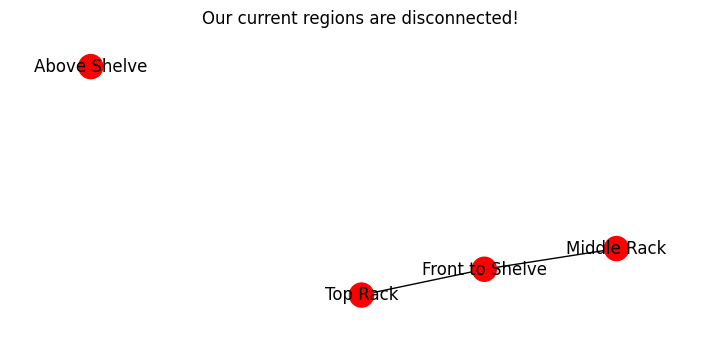

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

pre_existing_regions = [
    iris_regions["Middle Rack"],
    iris_regions["Front to Shelve"],
    iris_regions["Top Rack"],
    iris_regions["Above Shelve"],
]
labels = {0: "Middle Rack", 1: "Front to Shelve", 2: "Top Rack", 3: "Above Shelve"}

connectivity_graph = nx.Graph()
for idx in range(len(pre_existing_regions)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(pre_existing_regions)):
    for idx2 in range(idx1 + 1, len(pre_existing_regions)):
        r1 = pre_existing_regions[idx1]
        r2 = pre_existing_regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1, idx2)
colors = ["r"] * len(pre_existing_regions)

plt.figure(figsize=(7, 3))
nx.draw_spring(connectivity_graph, with_labels=True, node_color=colors, labels=labels)
plt.title("Our current regions are disconnected!")


# Adjust the plot to ensure all elements are visible
plt.margins(0.15)

In [33]:
# expect this cell to take around 1 - 2 minutes to run

vcc_regions = IrisInConfigurationSpaceFromCliqueCover(
    checker, vcc_opts, RandomGenerator(1337), pre_existing_regions
)

INFO:drake:Using default max clique solver MaxCliqueSolverViaGreedy.
INFO:drake:Current Fraction of Domain Covered = 0.1318
INFO:drake:IrisFromCliqueCover Iteration 1/2
INFO:drake:Clique added to queue. There are 217/400 points left to cover.
INFO:drake:Clique added to queue. There are 173/400 points left to cover.
INFO:drake:Clique added to queue. There are 144/400 points left to cover.
INFO:drake:Clique added to queue. There are 125/400 points left to cover.
INFO:drake:Clique added to queue. There are 110/400 points left to cover.
INFO:drake:Clique added to queue. There are 78/400 points left to cover.
INFO:drake:Clique added to queue. There are 65/400 points left to cover.
INFO:drake:Clique added to queue. There are 54/400 points left to cover.
INFO:drake:Clique added to queue. There are 38/400 points left to cover.
INFO:drake:Clique added to queue. There are 28/400 points left to cover.
INFO:drake:Clique added to queue. There are 18/400 points left to cover.
INFO:drake:Clique added

Text(0.5, 1.0, 'Connectivity graph of the regions, the three red nodes are the pre-existing regions')

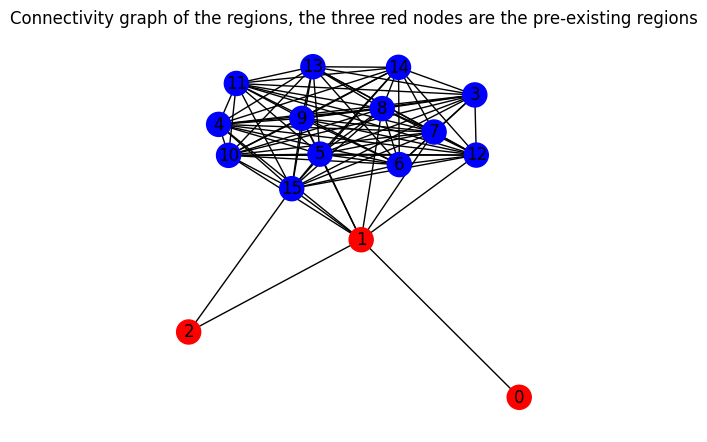

In [34]:
import matplotlib.pyplot as plt
import networkx as nx

connectivity_graph = nx.Graph()
for idx in range(len(vcc_regions)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(vcc_regions)):
    for idx2 in range(idx1 + 1, len(vcc_regions)):
        r1 = vcc_regions[idx1]
        r2 = vcc_regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1, idx2)
colors = ["b"] * len(vcc_regions)
colors[0] = "r"
colors[1] = "r"
colors[2] = "r"
plt.figure(figsize=(4, 4))
nx.draw_spring(connectivity_graph, with_labels=True, node_color=colors)
plt.title(
    "Connectivity graph of the regions, the three red nodes are the pre-existing regions"
)

# Getting good coverage of the bottom shelve
VCC currently attempts to cover cspace volume. In practice, it can be useful to guide the sampling distribution of the visibility graph to be non-uniform. Lets walk through an example! 

Suppose we now want to get task-space coverage of the bottom shelve. Here is a possible way to do it again following the 4 steps.

### Step 1: Sampling distribution

In [ ]:
# WIPWIPWIP

## Plan trajectories with GCS Trajectory Optimization

In [ ]:
from pydrake.geometry.optimization import GraphOfConvexSetsOptions, Point
from pydrake.planning import GcsTrajectoryOptimization


def PublishPositionTrajectory(
    trajectory, root_context, plant, visualizer, time_step=1.0 / 33.0
):
    """
    Args:
        trajectory: A Trajectory instance.
    """
    plant_context = plant.GetMyContextFromRoot(root_context)
    visualizer_context = visualizer.GetMyContextFromRoot(root_context)

    visualizer.StartRecording(False)

    for t in np.append(
        np.arange(trajectory.start_time(), trajectory.end_time(), time_step),
        trajectory.end_time(),
    ):
        root_context.SetTime(t)
        plant.SetPositions(plant_context, trajectory.value(t))
        visualizer.ForcedPublish(visualizer_context)

    visualizer.StopRecording()
    visualizer.PublishRecording()


def GcsTrajOpt(q_start, q_goal):
    if not iris_regions:
        print(
            "No IRIS regions loaded. Make some IRIS regions then come back and try this again."
        )
        return
    assert len(q_start) == len(q_goal)
    assert len(q_start) == iris_regions[next(iter(iris_regions))].ambient_dimension()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()
    AddDefaultVisualization(builder, meshcat)
    diagram = builder.Build()

    gcs = GcsTrajectoryOptimization(len(q_start))
    # TODO(russt): AddRegions should take named regions.
    regions = gcs.AddRegions(list(iris_regions.values()), order=1)
    source = gcs.AddRegions([Point(q_start)], order=0)
    target = gcs.AddRegions([Point(q_goal)], order=0)
    gcs.AddEdges(source, regions)
    gcs.AddEdges(regions, target)
    gcs.AddTimeCost()
    gcs.AddVelocityBounds(
        plant.GetVelocityLowerLimits(), plant.GetVelocityUpperLimits()
    )

    options = GraphOfConvexSetsOptions()
    options.preprocessing = True
    options.max_rounded_paths = 5
    start_time = time.time()
    traj, result = gcs.SolvePath(source, target, options)
    print(f"GCS solved in {time.time() - start_time} seconds")
    if not result.is_success():
        print("Could not find a feasible path from q_start to q_goal")
        return

    PublishPositionTrajectory(
        traj,
        diagram.CreateDefaultContext(),
        plant,
        diagram.GetSubsystemByName("meshcat_visualizer(illustration)"),
    )

In [ ]:
assert (
    seeds
), "The examples here use the 'manually-specified seeds' from the section above. Please run that section first, or populate your own start and end configurations."

GcsTrajOpt(seeds["Home Position"], seeds["Top Rack"])

In [ ]:
for k in range(4 if running_as_notebook else 0):
    GcsTrajOpt(seeds["Top Rack"], seeds["Left Bin"])
    GcsTrajOpt(seeds["Left Bin"], seeds["Middle Rack"])
    GcsTrajOpt(seeds["Middle Rack"], seeds["Right Bin"])
    GcsTrajOpt(seeds["Right Bin"], seeds["Top Rack"])

# Save your regions back to disk

Note that by default, this notebook will autosave a backup after making each region.

In [ ]:
if running_as_notebook:
    SaveIrisRegionsYamlFile(iris_filename, iris_regions)

# Clean up

For good measure, let's delete any temporary license files now.

In [ ]:
if os.path.exists("/tmp/mosek.lic"):
    os.remove("/tmp/mosek.lic")